In [24]:
! pip install numpy scipy matplotlib


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import math
import numpy as np
from utils import *
from scipy.stats import multinomial
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import scipy.io as sio

import warnings
warnings.filterwarnings("ignore")

In [42]:

from scipy.stats import multinomial
import scipy.io as sio
import numpy as np
import math


def Multinomial(A, B, alpha=0):
    """Fit multinomial over words with optional Dirichlet smoothing. Returns (pi, results dict)."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])

    # ML estimate with Dirichlet pseudocounts
    pi = np.array([np.sum(A[:, 2][A[:, 1] == w]) for w in range(1, W + 1)])
    pi = pi + alpha
    cc = np.copy(pi)
    pi = pi / np.sum(pi)

    unique_docs = np.unique(B[:, 0])
    res = {'cc': cc}

    for doc in unique_docs:
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1].flatten(), B[idx, 2].flatten()
        nd = np.sum(c)

        ow = np.zeros(W, dtype=int)
        for iw, ic in zip(w, c):
            ow[iw - 1] += ic

        lp = multinomial.logpmf(ow, n=nd, p=pi)
        res[doc] = (nd, lp, np.exp(-lp / nd))

    return pi, res


def Categorical(A, B, pi):
    """Log-prob under categorical (avoids multinomial coefficient). Handles zero-prob words."""
    logpi = np.log(pi)

    def logpmf(ow, n, lp, pi):
        assert sum(ow) == n
        mask = pi <= 0.0
        if np.sum(ow[mask]) > 0:
            return -np.inf
        return np.sum(np.where(mask, 0, ow * lp))

    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    unique_docs = np.unique(B[:, 0])
    res = {}

    for doc in unique_docs:
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1].flatten(), B[idx, 2].flatten()
        nd = np.sum(c)

        ow = np.zeros(W, dtype=int)
        for iw, ic in zip(w, c):
            ow[iw - 1] += ic

        lp = logpmf(ow, n=nd, lp=logpi, pi=pi)
        res[doc] = (nd, lp, np.exp(-lp / nd))

    return res


def LogBetaFunction(c):
    """Log of multivariate Beta function: log B(c) = sum log Gamma(c_i) - log Gamma(sum c_i)."""
    return sum(math.lgamma(q) for q in c) - math.lgamma(sum(c))


def LogDocumentProbability(c, c0):
    """Log predictive probability of doc counts c under Dirichlet posterior with pseudocounts c0."""
    return LogBetaFunction(c + c0) - LogBetaFunction(c0)


def DistributionExpectation(A, B, c0):
    """Per-document log-prob and perplexity using Dirichlet-multinomial (integrating out pi)."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    unique_docs = np.unique(B[:, 0])
    res = {}

    for doc in unique_docs:
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1].flatten(), B[idx, 2].flatten()
        nd = np.sum(c)

        ow = np.zeros(W, dtype=int)
        for iw, ic in zip(w, c):
            ow[iw - 1] += ic

        lp = LogDocumentProbability(ow, c0)
        res[doc] = (nd, lp, np.exp(-lp / nd))

    return res


In [27]:

A, B, V = load_ml("kos_doc_data.mat")


BAll = np.copy(B)
BAll[:, 0] = 2001

### Multinomial with Dirichlet prior

Likelihood: $p(\mathbf{x} \mid \boldsymbol{\pi}) \propto \prod_i \pi_i^{x_i}$. Conjugate prior: $p(\boldsymbol{\pi}) = \text{Dir}(\boldsymbol{\alpha})$.

Posterior: $p(\boldsymbol{\pi} \mid \mathbf{x}) = \text{Dir}(\mathbf{x} + \boldsymbol{\alpha})$

Predictive:

$$p(x = i \mid \mathbf{x}) = \mathbb{E}[\pi_i] = \frac{x_i + \alpha_i}{n + \alpha_0}$$

$\alpha = \mathbf{1}$ gives non-informative prior. Smoothing effect: rare words get more mass than ML. Specifically, the prior increases probability for word $i$ when $x_i \leq n\,\alpha_i / \alpha_0$ (i.e. $\leq n/K$ for symmetric Dirichlet). Overall pushes probabilities toward uniform.
`

In [43]:
def helper_function(A, B, V, T=20, alpha=1, rev=False, plot=True):
    """Fit multinomial, plot top words, print summary stats."""
    pi, res = Multinomial(A, B, alpha=alpha)

    spi, sV = zip(*sorted(zip(pi, V.flatten()), reverse=True))
    spi = np.array(spi)
    sV = np.array([w[0] for w in sV])

    fig = None
    if plot:
        fig = plt.figure(figsize=(12, 8))
        barplot(sV, spi, T=20, rev=rev)
        plt.xlim(0, 0.0001 if rev else 0.015)

    nds = np.array([res[k][0] for k in res]).flatten()
    lps = np.array([res[k][1] for k in res]).flatten()
    pps = np.array([res[k][2] for k in res]).flatten()

    print(f"Log-prob  — min: {np.min(lps):.2f}, mean: {np.mean(lps):.2f}, max: {np.max(lps):.2f}")
    print(f"Perplexity — min: {np.min(pps):.2f}, mean: {np.mean(pps):.2f}, max: {np.max(pps):.2f}")
    return pi, res, nds, lps, pps, fig

Min, average and max log-prob -inf -inf 17.0
Min, average and max perplexity 13.0 inf inf


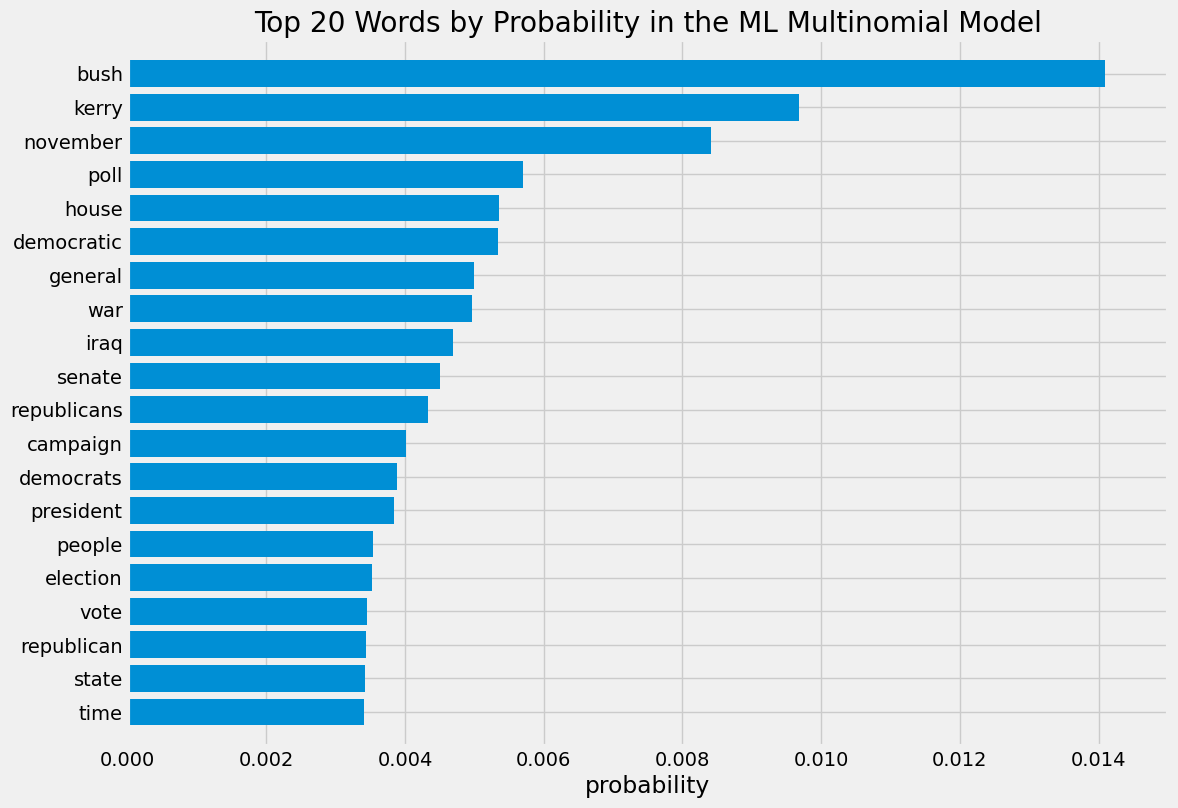

In [29]:
pi0, res, nds, lps, pps, fig = helper_function(A, B, V, alpha = 0)
fig.tight_layout()
plt.title('Top 20 Words by Probability in the ML Multinomial Model')
plt.show()

Min, average and max log-prob -2261.4482749374247 -590.0259127532299 117.0
Min, average and max perplexity 21.519322349305565 135.11356014688474 542.6731196207728


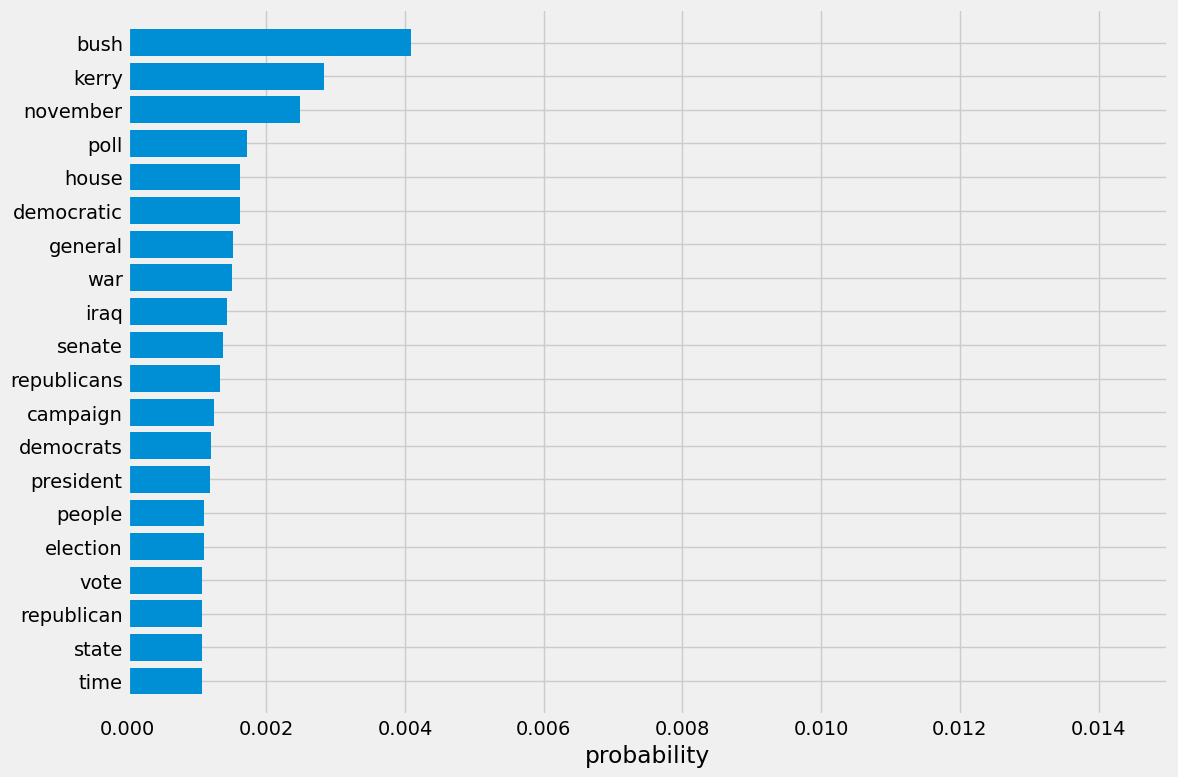

In [30]:
pi, res, nds, lps, pps, fig = helper_function(A, B, V, alpha = 100)
fig.tight_layout()
plt.show()

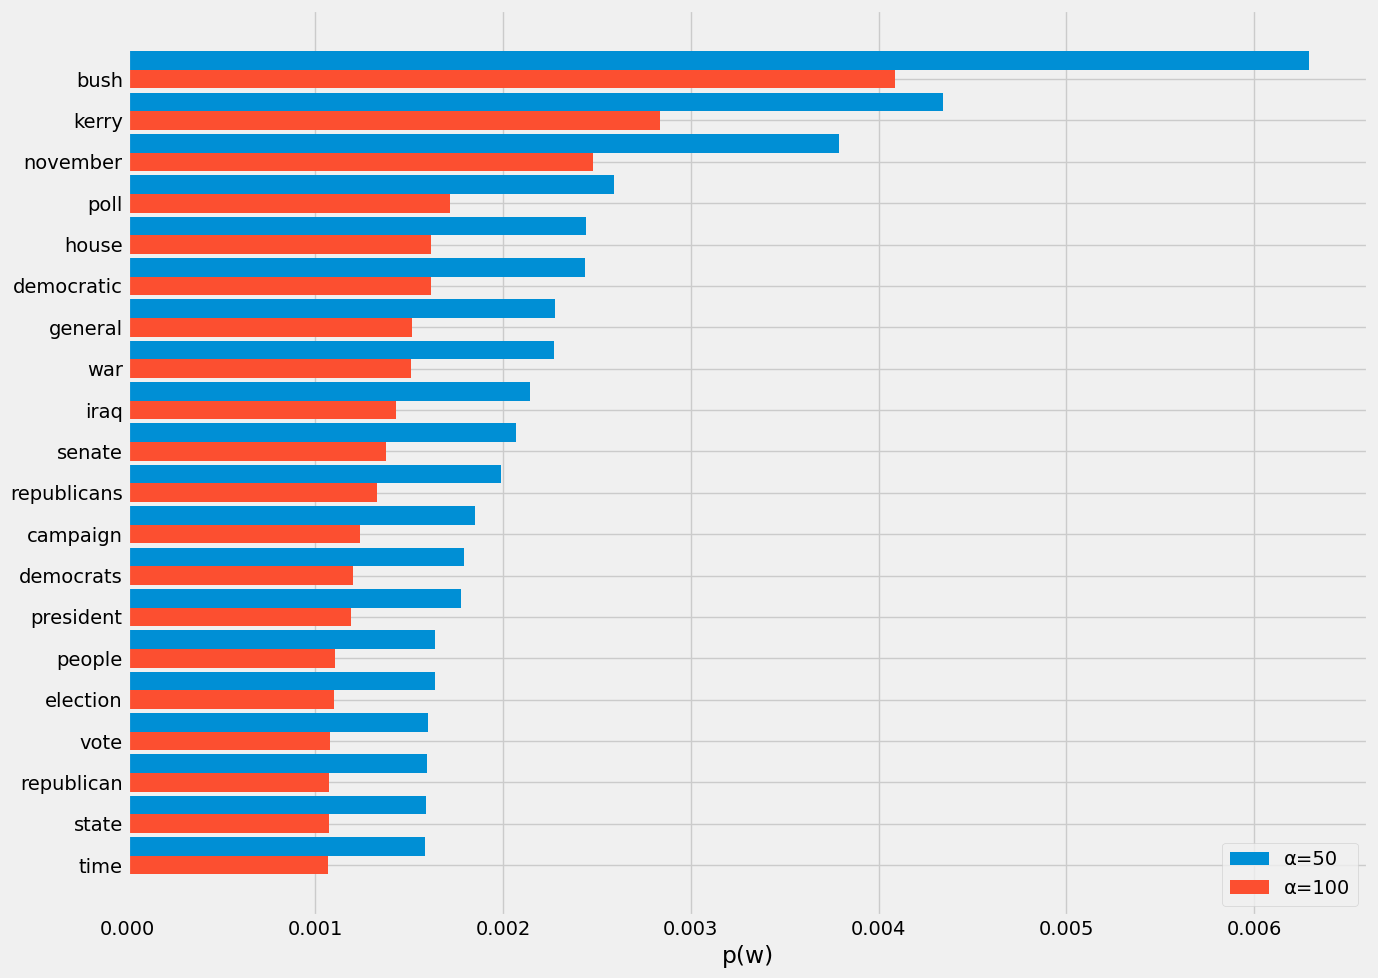

In [44]:
def helper_function_2(A, B, V, T=20, alphas=[5, 100], rev=False, plot=True):
    results = {}
    for alpha in alphas:
        pi, res = Multinomial(A, B, alpha=alpha)
        spi, sV = zip(*sorted(zip(pi, V.flatten()), reverse=True))
        results[alpha] = (np.array(spi), np.array([w[0] for w in sV]))

    if plot:
        fig, ax = plt.subplots(figsize=(14, 10))
        bw = 0.45
        pos = np.arange(T)

        for i, alpha in enumerate(alphas):
            spi, sV = results[alpha]
            ax.barh(pos + i*bw, spi[:T], height=bw, label=f'α={alpha}')

        ax.set_yticks(pos + bw)
        ax.set_yticklabels(results[alphas[0]][1][:T])
        ax.set_xlabel('p(w)')
        ax.legend()
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()

    return results

results = helper_function_2(A, B, V, alphas=[50, 100])

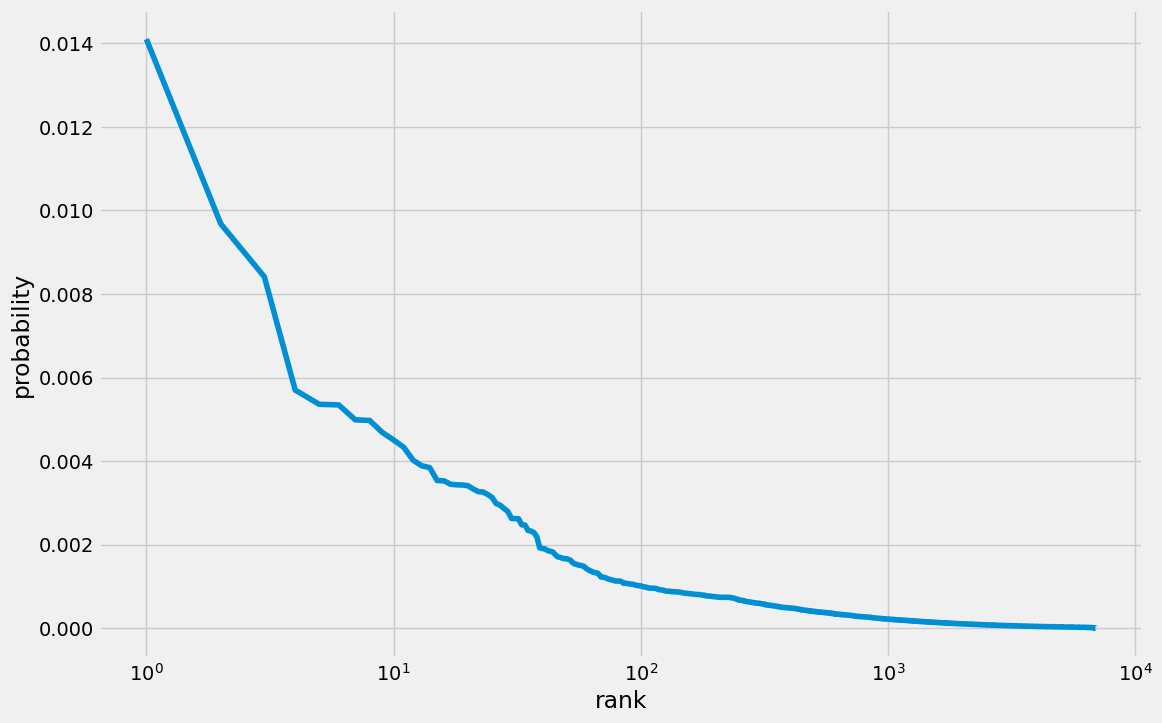

In [45]:
plt.figure(figsize = (12, 8))
plt.semilogx(np.arange(1, len(pi) + 1), np.sort(pi0)[::-1])
plt.ylabel('probability')
plt.xlabel('rank')

fig.tight_layout()
plt.show()

In [ ]:
c0 = np.copy(res['cc'])

Perplexity at document and global level. Bag-of-words means ordering is irrelevant — categorical vs multinomial differ only by a combinatorial factor independent of parameters. Use multinomial for convenience. Point estimates first.

In [46]:
def helper_function_cat(A, B, pi):
    res = Categorical(A, B, pi)
    
    nds = np.array([res[k][0] for k in res.keys()]).flatten()
    lps = np.array([res[k][1] for k in res.keys()]).flatten()
    pps = np.array([res[k][2] for k in res.keys()]).flatten()
    
    print("Min, average and max log-prob", np.min(lps), np.mean(lps), np.max(lps))
    print("Min, average and max perplexity", np.min(pps), np.mean(pps), np.max(pps))
    return pi, res, nds, lps, pps

In [35]:
#extract information for document 2001
_, res, nds, lps, pps = helper_function_cat(A, B, pi)
print("ID 2001. Size: {},   LP: {:.3f},   PPS: {:.3f}".format(*res[2001]))

Min, average and max log-prob -5181.226653145406 -1125.189221529493 -197.670785114644
Min, average and max perplexity 1101.2928501144536 3762.902371819268 6038.306062838549
ID 2001. Size: 440,   LP: -3744.225,   PPS: 4962.193


In [36]:
#extract information for all document
_, res, nds, lps, pps = helper_function_cat(A, BAll, pi)
print("ID 2001. Size: {},   LP: {:.3f},   PPS: {:.3f}".format(*res[2001]))

Min, average and max log-prob -1609020.586787175 -1609020.586787175 -1609020.586787175
Min, average and max perplexity 3703.385309861389 3703.385309861389 3703.385309861389
ID 2001. Size: 195816,   LP: -1609020.587,   PPS: 3703.385


In [37]:
_, res, nds, lps, pps = helper_function_cat(A, B, (c0 - 1)/(np.sum(c0 - 1)))
print("ID 2001. Size: {},   LP: {:.3f},   PPS: {:.3f}".format(*res[2001]))

Min, average and max log-prob -5179.713442062828 -1124.88973535208 -197.56699886310219
Min, average and max perplexity 1095.5196435219261 3755.2586265977766 6036.3343986465325
ID 2001. Size: 440,   LP: -3743.680,   PPS: 4956.050


In [38]:
_, res, nds, lps, pps = helper_function_cat(A, BAll, (c0 - 1)/(np.sum(c0 - 1)))
print("ID 2001. Size: {},   LP: {:.3f},   PPS: {:.3f}".format(*res[2001]))

Min, average and max log-prob -1608592.3215534743 -1608592.3215534743 -1608592.3215534743
Min, average and max perplexity 3695.2945611457562 3695.2945611457562 3695.2945611457562
ID 2001. Size: 195816,   LP: -1608592.322,   PPS: 3695.295


```
    For the last part we compute the integral expectation
```

In [ ]:
def helper_function_int(A, B, c0):
    
    res = DistributionExpectation(A, B, c0)
    
    nds = np.array([res[k][0] for k in res.keys()]).flatten()
    lps = np.array([res[k][1] for k in res.keys()]).flatten()
    pps = np.array([res[k][2] for k in res.keys()]).flatten()
    
    print("Min, average and max log-prob", np.min(lps), np.mean(lps), np.max(lps))
    print("Min, average and max perplexity", np.min(pps), np.mean(pps), np.max(pps))
    return pi, res, nds, lps, pps

In [40]:
_, res, nds, lps, pps = helper_function_int(A, B, c0)
print("ID 2001. Size: {},   LP: {:.3f},   PPS: {:.3f}".format(*res[2001]))

Min, average and max log-prob -5179.7705106809735 -1124.9385054466895 -197.66272523254156
Min, average and max perplexity 1100.7539496147422 3757.354946649477 6017.462624215838
ID 2001. Size: 440,   LP: -3741.431,   PPS: 4930.775


In [41]:
_, res, nds, lps, pps = helper_function_int(A, BAll, c0)
print("ID 2001. Size: {},   LP: {:.3f},   PPS: {:.3f}".format(*res[2001]))

Min, average and max log-prob -1596414.0474030674 -1596414.0474030674 -1596414.0474030674
Min, average and max perplexity 3472.475824195219 3472.475824195219 3472.475824195219
ID 2001. Size: 195816,   LP: -1596414.047,   PPS: 3472.476
